# Model Evaluation on 2020 Dataset

In [0]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, udf
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, OneHotEncoder, PCA
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.classification import LogisticRegressionModel, DecisionTreeClassificationModel, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import FloatType, DoubleType, StructType, StructField, StringType, IntegerType
from pyspark.ml.feature import Imputer
from graphframes import *
from joblibspark import register_spark
from joblib import Parallel, delayed

from sparkdl.xgboost import XgboostClassifier, XgboostClassifierModel

spark.sparkContext.addPyFile("dbfs:/custom_cv.py")
from custom_cv import CustomCrossValidator
 
sqlContext = SQLContext(sc)

In [0]:
# Configuration for Blob Storage 

blob_container = "container1" # The name of your container created in https://portal.azure.com
storage_account = "w261sp22team12" # The name of your Storage account created in https://portal.azure.com
secret_scope = "s1" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "k1" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

In [0]:
# SAS Token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# Set partitions
spark.conf.set("spark.sql.shuffle.partitions", 1000)
spark.conf.set("spark.sql.files.minPartitionNum", 1000)

In [0]:
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))

In [0]:
def mergeDataframes(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [0]:
pd.set_option('display.max_columns', None)

## Data

### 2020 Airlines

In [0]:
df_airlines = spark.read.parquet(f"{blob_url}/airlines_2020_airport_airline_ripple_agg") \
                        .repartition(1000, 'fl_date') \
                        .persist()

In [0]:
print(sparkShape(df_airlines))

(4293408, 51)

In [0]:
display(df_airlines)

year quarter month day_of_month day_of_week fl_date time_zone origin origin_icao origin_city_name origin_airport_id origin_state_abr dest_airport_id dest_state_abr dest_city_name dest dest_icao op_unique_carrier op_carrier_airline_id op_carrier_fl_num tail_num dep_time_blk arr_time_blk crs_dep_time crs_arr_time crs_elapsed_time distance distance_group dep_delay_new dep_del15 cancelled dep_time arr_time arr_delay_new local_tz local_crs_arr_tz local_arr_tz fl_tz pwnd_date pwnd_blk dwnd_blk total_flights delayed_flights avg_delayed_mins pct_flight_delayed airline_total_flights airline_delayed_flights airline_avg_delayed_mins airline_pct_flight_delayed prev_flight_arr_delay timediff 2020 2 6 20 6 2020-06-20 America/New_York CHS KCHS Charleston, SC 10994 SC 12264 VA Washington, DC IAD KIAD YV 20378 6030 N515MJ 1500-1559 1600-1659 1500 1624 84.0 441.0 2 0.0 0.0 0 1500 1630 6.0 2020-06-20T15:00:00.000+0000 2020-06-20T16:24:00.000+0000 2020-06-20T16:30:00.000+0000 2020-06-20T19:00:00.000+0000 2020-06-20 1200-1259 1500-1559 1 0.0 0.0 0.0 0 0.0 0.0 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/Chicago DFW KDFW Dallas/Fort Worth, TX 11298 TX 14689 CA Santa Barbara, CA SBA KSBA YV 20378 5790 N918FJ 1000-1059 1200-1259 1050 1217 207.0 1316.0 6 9.0 0.0 0 1059 1211 0.0 2020-06-20T10:50:00.000+0000 2020-06-20T12:17:00.000+0000 2020-06-20T12:17:00.000+0000 2020-06-20T15:50:00.000+0000 2020-06-20 0700-0759 1000-1059 8 1.0 31.875 12.5 1 0.0 0.0 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/Chicago DFW KDFW Dallas/Fort Worth, TX 11298 TX 14457 SD Rapid City, SD RAP KRAP YV 20378 5814 N950LR 1000-1059 1100-1159 1028 1148 140.0 835.0 4 0.0 0.0 0 1023 1131 0.0 2020-06-20T10:28:00.000+0000 2020-06-20T11:48:00.000+0000 2020-06-20T11:48:00.000+0000 2020-06-20T15:28:00.000+0000 2020-06-20 0700-0759 1000-1059 8 1.0 31.875 12.5 1 0.0 0.0 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/Los_Angeles PDX KPDX Portland, OR 14057 OR 14107 AZ Phoenix, AZ PHX KPHX AA 19805 1083 N343PN 1200-1259 1500-1559 1254 1525 151.0 1009.0 5 169.0 1.0 0 1543 1813 168.0 2020-06-20T12:54:00.000+0000 2020-06-20T15:25:00.000+0000 2020-06-20T18:13:00.000+0000 2020-06-20T19:54:00.000+0000 2020-06-20 0900-0959 1200-1259 3 0.0 0.0 0.0 0 0.0 0.0 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/Chicago HOU KHOU Houston, TX 12191 TX 13495 LA New Orleans, LA MSY KMSY WN 19393 1958 N230WN 1400-1459 1500-1559 1415 1525 70.0 302.0 2 0.0 0.0 0 1410 1518 0.0 2020-06-20T14:15:00.000+0000 2020-06-20T15:25:00.000+0000 2020-06-20T15:25:00.000+0000 2020-06-20T19:15:00.000+0000 2020-06-20 1100-1159 1400-1459 4 0.0 5.5 0.0 4 0.0 5.5 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/Los_Angeles LAX KLAX Los Angeles, CA 12892 CA 14831 CA San Jose, CA SJC KSJC OO 20304 3951 N268SY 0900-0959 1000-1059 0940 1056 76.0 308.0 2 0.0 0.0 0 0934 1033 0.0 2020-06-20T09:40:00.000+0000 2020-06-20T10:56:00.000+0000 2020-06-20T10:56:00.000+0000 2020-06-20T16:40:00.000+0000 2020-06-20 0600-0659 0900-0959 8 0.0 0.75 0.0 0 0.0 0.0 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/Chicago DFW KDFW Dallas/Fort Worth, TX 11298 TX 12891 OK Lawton/Fort Sill, OK LAW KLAW MQ 20398 3395 N696AE 1800-1859 1900-1959 1835 1931 56.0 140.0 1 33.0 1.0 0 1908 2000 29.0 2020-06-20T18:35:00.000+0000 2020-06-20T19:31:00.000+0000 2020-06-20T20:00:00.000+0000 2020-06-20T23:35:00.000+0000 2020-06-20 1500-1559 1800-1859 16 3.0 21.5 18.75 3 0.0 0.0 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/New_York ATL KATL Atlanta, GA 10397 GA 11259 TX Dallas, TX DAL KDAL DL 19790 1799 N896AT 1400-1459 1500-1559 1409 1513 124.0 721.0 3 0.0 0.0 0 1409 1506 0.0 2020-06-20T14:09:00.000+0000 2020-06-20T15:13:00.000+0000 2020-06-20T15:13:00.000+0000 2020-06-20T18:09:00.000+0000 2020-06-20 1100-1159 1400-1459 40 0.0 0.9 0.0 22 0.0 1.090909 0.0 0.0 0.0 2020 2 6 20 6 2020-06-20 America/Los_Angeles SNA KSNA Santa Ana, CA 14908 CA 12889 NV Las Vegas, NV LAS KLAS WN 19393 1525 N477WN 1600-1659 1800-1859 1650 1800 70.0 226.0 1 0.0 0.0 0 1647 1743 0.0 2020-06-20T16:50:00.000+0000 2020-

In [0]:
df_airlines.createOrReplaceTempView('airlines')

### 2020 Weather

In [0]:
df_weather = spark.read.parquet(f"{blob_url}/weather_2020") \
                        .repartition(1000, 'fl_date') \
                        .persist()

In [0]:
df_weather.createOrReplaceTempView('weather')

### Joins

#### Airlines joined with 2-3 top ranked weather stations

In [0]:
# Join with airline data
# We want to find flight and weather data that happened 2-3 hours before a flight departure

def joinWithInterval(start=3, end=2):
    query_string = f'''
        SELECT 
            /*+ REPARTITION(1000) */
            
            airlines.fl_tz,
            airlines.origin_icao,
            airlines.dest_icao,
            airlines.tail_num,
            
            airlines.fl_date,
            
            airlines.op_unique_carrier,
            airlines.op_carrier_airline_id,
            airlines.op_carrier_fl_num,
            
            airlines.year,
            airlines.quarter,
            airlines.month,
            airlines.day_of_month,
            airlines.day_of_week,
            airlines.dwnd_blk,
            
            airlines.dep_del15,
            airlines.dep_delay_new,
            
            airlines.distance,
            airlines.total_flights,
            airlines.delayed_flights,
            airlines.avg_delayed_mins,
            airlines.pct_flight_delayed,
            airlines.airline_total_flights,
            airlines.airline_delayed_flights,
            airlines.airline_avg_delayed_mins,
            airlines.airline_pct_flight_delayed,
            airlines.prev_flight_arr_delay,
            airlines.timediff,

            weather.wind_directional_angle,
            weather.wind_directional_speed_rate,
            weather.sky_ceiling_height_dimension,
            weather.vis_distance,
            weather.air_temperature,
            weather.dew_point_temperature,
            weather.sea_level_pressure,
            weather.lp_period_qty,
            weather.ap_altimeter_setting_rate,
            weather.sky_height_dimension,
            weather.sky_convective_cloud_attribute,
            weather.snow_depth_dimension,
            weather.snow_depth_equivalent_water_depth
            
        FROM airlines
        INNER JOIN weather ON airlines.origin_icao = weather.airport_icao AND
                              airlines.fl_date = weather.fl_date AND
                              weather.date BETWEEN (fl_tz - INTERVAL {start} hours) AND (fl_tz - INTERVAL {end} hours)
    '''
    df = spark.sql(query_string)
    return df

In [0]:
df_airlines_weather = joinWithInterval().persist()

In [0]:
print("airlines with 2 top ranked stations", sparkShape(df_airlines_weather))
display(df_airlines_weather)

airlines with 2 top ranked stations (8789697, 40)

fl_tz origin_icao dest_icao tail_num fl_date op_unique_carrier op_carrier_airline_id op_carrier_fl_num year quarter month day_of_month day_of_week dwnd_blk dep_del15 dep_delay_new distance total_flights delayed_flights avg_delayed_mins pct_flight_delayed airline_total_flights airline_delayed_flights airline_avg_delayed_mins airline_pct_flight_delayed prev_flight_arr_delay timediff wind_directional_angle wind_directional_speed_rate sky_ceiling_height_dimension vis_distance air_temperature dew_point_temperature sea_level_pressure lp_period_qty ap_altimeter_setting_rate sky_height_dimension sky_convective_cloud_attribute snow_depth_dimension snow_depth_equivalent_water_depth 2020-12-19T22:40:00.000+0000 KRNO KSAN N8625A 2020-12-19 WN 19393 1681 2020 4 12 19 6 1400-1459 1.0 28.0 488.0 2 0.0 0.0 0.0 0 0.0 0.0 0.0 0.0 0.0 null 0.0 22000.0 16093.0 90.0 -70.0 null null null null null null null 2020-10-27T15:20:00.000+0000 KSMF KHNL N205HA 2020-10-27 HA 19690 19 2020 4 10 27 2 0800-0859 0.0 2.0 2462.0 1 0.0 0.0 0.0 0 0.0 0.0 0.0 0.0 0.0 null 0.0 22000.0 14484.0 110.0 -30.0 null null null null null null null 2020-09-16T13:15:00.000+0000 KFLL KBWI N8697C 2020-09-16 WN 19393 2005 2020 3 9 16 3 0900-0959 0.0 0.0 925.0 1 0.0 0.0 0.0 0 0.0 0.0 0.0 0.0 0.0 140.0 36.0 22000.0 16093.0 283.0 250.0 10139.0 null null null null null null 2020-01-17T00:35:00.000+0000 KSLC KPHX N781WN 2020-01-16 WN 19393 2142 2020 1 1 16 4 1700-1759 1.0 22.0 507.0 12 3.0 22.75 25.0 1 0.0 7.0 0.0 0.0 0.0 150.0 77.0 22000.0 16093.0 87.0 -14.0 null null null null null null null 2020-11-27T19:01:00.000+0000 KDAB KATL N341NB 2020-11-27 DL 19790 2301 2020 4 11 27 5 1400-1459 0.0 0.0 366.0 1 0.0 0.0 0.0 1 0.0 0.0 0.0 0.0 0.0 null 21.0 22000.0 16093.0 261.0 194.0 10198.0 null null null null null null 2020-02-09T17:00:00.000+0000 KBNA KPHX N709SW 2020-02-09 WN 19393 3574 2020 1 2 9 7 1100-1159 0.0 6.0 1449.0 18 0.0 0.388889 0.0 11 0.0 0.636364 0.0 0.0 0.0 150.0 26.0 22000.0 16093.0 39.0 0.0 10298.0 null null null null null null 2020-12-07T01:04:00.000+0000 KGEG KSLC N355NB 2020-12-06 DL 19790 1491 2020 4 12 6 7 1700-1759 0.0 0.0 546.0 1 0.0 0.0 0.0 0 0.0 0.0 0.0 0.0 0.0 160.0 15.0 91.0 3219.0 -33.0 -50.0 10347.0 null null null null null null 2020-06-14T23:45:00.000+0000 KSEA KSLC N170SY 2020-06-14 OO 20304 3349 2020 2 6 14 7 1600-1659 0.0 1.0 689.0 19 0.0 0.315789 0.0 5 0.0 0.0 0.0 0.0 0.0 null 21.0 1829.0 16093.0 167.0 56.0 10175.0 null null null null null null 2020-02-12T21:05:00.000+0000 KLAS KTUS N248WN 2020-02-12 WN 19393 1319 2020 1 2 12 3 1300-1359 0.0 0.0 365.0 24 2.0 6.958333 8.333333333333334 10 1.0 8.2 10.0 0.0 0.0 null 15.0 22000.0 16093.0 139.0 -122.0 10192.0 null null null null null null 2020-07-23T17:00:00.000+0000 KTUL KIAH N16987 2020-07-23 EV 20366 4012 2020 3 7 23 4 1200-1259 0.0 0.0 429.0 2 0.0 0.0 0.0 0 0.0 0.0 0.0 0.0 0.0 140.0 31.0 610.0 16093.0 272.0 233.0 10173.0 null null null null null null 2020-10-11T15:45:00.000+0000 KDEN KEWR N17139 2020-10-11 UA 19977 1729 2020 4 10 11 7 0900-0959 1.0 188.0 1605.0 19 1.0 5.315789 5.2631578947368425 1 0.0 0.0 0.0 0.0 0.0 200.0 62.0 22000.0 16093.0 150.0 -67.0 9997.0 10068.0 null null null null null 2020-02-12T18:00:00.000+0000 KLAS KMDW N8696E 2020-02-12 WN 19393 320 2020 1 2 12 3 1000-1059 0.0 0.0 1521.0 25 0.0 0.28 0.0 10 0.0 0.7 0.0 0.0 0.0 170.0 31.0 22000.0 16093.0 61.0 -122.0 10209.0 null null 99.0 null 10183.0 5.0 2020-02-13T02:25:00.000+0000 KLAS KRNO N7713A 2020-02-12 WN 19393 5761 2020 1 2 12 3 1800-1859 0.0 3.0 345.0 32 3.0 17.96875 9.375 17 1.0 9.705882 5.882352941176471 0.0 0.0 40.0 21.0 22000.0 16093.0 161.0 -94.0 10182.0 null null 99.0 null 10166.0 5.0 2020-11-11T14:15:00.000+0000 KBNA KDAL N7867A 2020-11-11 WN 19393 205 2020 4 11 11 3 0800-0859 0.0 0.0 623.0 2 1.0 24.5 50.0 0 0.0 0.0 0.0 0.0 0.0 null 0.0 335.0 14484.0 194.0 194.0 10138.0 null null 1280.0 null 60.0 1.0 2020-11-11T12:15:00.000+0000 KBNA KDTW N3741S 2020-11-11 DL 19790 1232 2020 4 11 11 3 0600-0659 0.0 0.0 456.0 0 0.0 0.0 0.0 0 0.0 0

In [0]:
df_airlines_weather.createOrReplaceTempView('airlines_weather')

#### Aggregate weather data for each flight

In [0]:
def aggStations():
    query_string = '''
        SELECT
            /*+ REPARTITION(1000) */

            fl_tz,
            origin_icao,
            dest_icao,
            tail_num,
            
            last(fl_date) AS fl_date,
            last(op_unique_carrier) AS op_unique_carrier,
            last(op_carrier_airline_id) AS op_carrier_airline_id,
            last(op_carrier_fl_num) AS op_carrier_fl_num,
            
            last(year) AS year,
            last(quarter) AS quarter,
            last(month) AS month,
            last(day_of_month) AS day_of_month,
            last(day_of_week) AS day_of_week,
            last(dwnd_blk) AS dwnd_blk,
            
            avg(dep_del15) AS dep_del15,
            avg(dep_delay_new) AS dep_delay_new,
            
            avg(distance) AS distance,
            avg(total_flights) AS airport_total_flights_pwnd,
            avg(delayed_flights) AS airport_delayed_flights_pwnd,
            avg(avg_delayed_mins) AS airport_delayed_mins_pwnd,
            avg(pct_flight_delayed) AS airport_pct_flight_delayed,
            avg(airline_total_flights) AS airline_total_flights_pwnd,
            avg(airline_delayed_flights) AS airline_delayed_flights_pwnd,
            avg(airline_avg_delayed_mins) AS airline_delayed_mins_pwnd,
            avg(airline_pct_flight_delayed) AS airline_pct_flight_delayed,
            avg(prev_flight_arr_delay) AS ripple_effect_delay,
            avg(timediff) AS timediff_prev_flight,

            avg(wind_directional_angle) AS avg_wind_directional_angle,
            avg(wind_directional_speed_rate) AS avg_wind_directional_speed_rate,
            avg(sky_ceiling_height_dimension) AS avg_sky_ceiling_height_dimension,
            avg(vis_distance) AS avg_vis_distance,
            avg(air_temperature) AS avg_air_temperature,
            avg(dew_point_temperature) AS avg_dew_point_temperature,
            avg(sea_level_pressure) AS avg_sea_level_pressure,
            avg(lp_period_qty) AS avg_lp_period_qty,
            avg(ap_altimeter_setting_rate) as avg_ap_altimeter_setting_rate,
            avg(sky_height_dimension) AS avg_sky_height_dimension,
            avg(sky_convective_cloud_attribute) AS avg_sky_convective_cloud_attribute,
            avg(snow_depth_dimension) AS avg_snow_depth_dimension,
            avg(snow_depth_equivalent_water_depth) AS avg_snow_depth_equivalent_water_depth,
            
            min(wind_directional_angle) AS min_wind_directional_angle,
            min(wind_directional_speed_rate) AS min_wind_directional_speed_rate,
            min(sky_ceiling_height_dimension) AS min_sky_ceiling_height_dimension,
            min(vis_distance) AS min_vis_distance,
            min(air_temperature) AS min_air_temperature,
            min(dew_point_temperature) AS min_dew_point_temperature,
            min(sea_level_pressure) AS min_sea_level_pressure,
            min(lp_period_qty) AS min_lp_period_qty,
            min(ap_altimeter_setting_rate) AS min_ap_altimeter_setting_rate,
            min(sky_height_dimension) AS min_sky_height_dimension,
            min(sky_convective_cloud_attribute) AS min_sky_convective_cloud_attribute,
            min(snow_depth_dimension) AS min_snow_depth_dimension,
            min(snow_depth_equivalent_water_depth) AS min_snow_depth_equivalent_water_depth,
            
            max(wind_directional_angle) AS max_wind_directional_angle,
            max(wind_directional_speed_rate) AS max_wind_directional_speed_rate,
            max(sky_ceiling_height_dimension) AS max_sky_ceiling_height_dimension,
            max(vis_distance) AS max_vis_distance,
            max(air_temperature) AS max_air_temperature,
            max(dew_point_temperature) AS max_dew_point_temperature,
            max(sea_level_pressure) AS max_sea_level_pressure,
            max(lp_period_qty) AS max_lp_period_qty,
            max(ap_altimeter_setting_rate) AS max_ap_altimeter_setting_rate,
            max(sky_height_dimension) AS max_sky_height_dimension,
            max(sky_convective_cloud_attribute) AS max_sky_convective_cloud_attribute,
            max(snow_depth_dimension) AS max_snow_depth_dimension,
            max(snow_depth_equivalent_water_depth) AS max_snow_depth_equivalent_water_depth   
            
        FROM airlines_weather
        GROUP BY fl_tz, origin_icao, dest_icao, tail_num, op_carrier_airline_id, op_carrier_fl_num
    '''
    df = spark.sql(query_string)
    return df

In [0]:
df_airlines_weather_agg = aggStations().persist()

In [0]:
print("airlines agg stations", sparkShape(df_airlines_weather_agg))

airlines agg stations (4117418, 66)

In [0]:
display(df_airlines_weather_agg)

fl_tz origin_icao dest_icao tail_num fl_date op_unique_carrier op_carrier_airline_id op_carrier_fl_num year quarter month day_of_month day_of_week dwnd_blk dep_del15 dep_delay_new distance airport_total_flights_pwnd airport_delayed_flights_pwnd airport_delayed_mins_pwnd airport_pct_flight_delayed airline_total_flights_pwnd airline_delayed_flights_pwnd airline_delayed_mins_pwnd airline_pct_flight_delayed ripple_effect_delay timediff_prev_flight avg_wind_directional_angle avg_wind_directional_speed_rate avg_sky_ceiling_height_dimension avg_vis_distance avg_air_temperature avg_dew_point_temperature avg_sea_level_pressure avg_lp_period_qty avg_ap_altimeter_setting_rate avg_sky_height_dimension avg_sky_convective_cloud_attribute avg_snow_depth_dimension avg_snow_depth_equivalent_water_depth min_wind_directional_angle min_wind_directional_speed_rate min_sky_ceiling_height_dimension min_vis_distance min_air_temperature min_dew_point_temperature min_sea_level_pressure min_lp_period_qty min_ap_altimeter_setting_rate min_sky_height_dimension min_sky_convective_cloud_attribute min_snow_depth_dimension min_snow_depth_equivalent_water_depth max_wind_directional_angle max_wind_directional_speed_rate max_sky_ceiling_height_dimension max_vis_distance max_air_temperature max_dew_point_temperature max_sea_level_pressure max_lp_period_qty max_ap_altimeter_setting_rate max_sky_height_dimension max_sky_convective_cloud_attribute max_snow_depth_dimension max_snow_depth_equivalent_water_depth 2020-10-22T14:20:00.000+0000 KLAS KHNL N204HA 2020-10-22 HA 19690 7 2020 4 10 22 4 0700-0759 0.0 0.0 2762.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 255.0 28.5 22000.0 16093.0 177.5 -33.5 10072.5 null null 99.0 null 10091.0 9.0 210.0 26.0 22000.0 16093.0 172.0 -39.0 10061.0 null null 99.0 null 10091.0 9.0 300.0 31.0 22000.0 16093.0 183.0 -28.0 10084.0 null null 99.0 null 10091.0 9.0 2020-08-30T19:00:00.000+0000 KATL KMSY N230WN 2020-08-30 WN 19393 523 2020 3 8 30 7 1500-1559 0.0 0.0 425.0 41.0 6.0 9.878049 14.634146341463415 1.0 0.0 0.0 0.0 0.0 0.0 340.0 23.5 1356.5 16093.0 308.5 222.0 10107.0 10122.0 null null null null null 340.0 21.0 1311.0 16093.0 300.0 222.0 10105.0 10122.0 null null null null null 340.0 26.0 1402.0 16093.0 317.0 222.0 10109.0 10122.0 null null null null null 2020-02-27T13:30:00.000+0000 KIAH KOKC N85320 2020-02-27 YV 20378 6233 2020 1 2 27 4 0700-0759 0.0 0.0 395.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 22000.0 16093.0 -2.5 -30.5 10302.5 null null null null null null null 0.0 22000.0 16093.0 -11.0 -39.0 10302.0 null null null null null null null 0.0 22000.0 16093.0 6.0 -22.0 10303.0 null null null null null null 2020-01-28T15:05:00.000+0000 KFLL KHOU N8612K 2020-01-28 WN 19393 2187 2020 1 1 28 2 1000-1059 1.0 74.0 957.0 22.0 0.0 0.136364 0.0 4.0 0.0 0.0 0.0 0.0 0.0 340.0 23.5 60.5 603.5 180.5 172.0 10132.5 null null null null 0.0 2.0 330.0 21.0 30.0 402.0 178.0 172.0 10129.0 null null null null 0.0 2.0 350.0 26.0 91.0 805.0 183.0 172.0 10136.0 null null null null 0.0 2.0 2020-04-07T10:36:00.000+0000 KSDF KCLT N561NN 2020-04-07 OH 20397 5523 2020 2 4 7 2 0600-0659 0.0 0.0 335.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 155.0 18.0 11914.5 16093.0 158.5 116.5 10137.0 null null null null null null 150.0 15.0 1829.0 16093.0 156.0 111.0 10137.0 null null null null null null 160.0 21.0 22000.0 16093.0 161.0 122.0 10137.0 null null null null null null 2020-05-27T17:30:00.000+0000 KOMA KDEN N7877H 2020-05-27 WN 19393 851 2020 2 5 27 3 1200-1259 0.0 0.0 472.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 267.5 48.75 297.0 6035.0 172.0 167.75 10118.0 null null null 0.0 null null 10.0 36.0 152.0 3219.0 170.0 161.0 10118.0 null null null 0.0 null null 360.0 67.0 640.0 9656.0 178.0 170.0 10118.0 null null null 0.0 null null 2020-12-23T20:39:00.000+0000 KMCO KACY N655NK 2020-12-23 NK 20416 138 2020 4 12 23 3 1500-1559 0.0 0.0 852.0 22.0 2.0 1.545455 9.090909090909092 1.0 0.0 0.0 0.0 0.0 0.0 110.0 51.0 22000.0 16093.0 228.0 133.0 10221.0 null null null 

In [0]:
df_airlines_weather_agg.write.mode('overwrite').parquet(f"{blob_url}/airlines_agg_2020")

In [0]:
df_airlines_weather_agg = spark.read.parquet(f"{blob_url}/airlines_agg_2020") \
                                    .repartition(1000, 'fl_date') \
                                    .persist()

In [0]:
df_airlines_weather_agg.createOrReplaceTempView('airlines_agg')

In [0]:
print("airlines agg stations", sparkShape(df_airlines_weather_agg))
display(df_airlines_weather_agg)

airlines agg stations (4117418, 66)

fl_tz origin_icao dest_icao tail_num fl_date op_unique_carrier op_carrier_airline_id op_carrier_fl_num year quarter month day_of_month day_of_week dwnd_blk dep_del15 dep_delay_new distance airport_total_flights_pwnd airport_delayed_flights_pwnd airport_delayed_mins_pwnd airport_pct_flight_delayed airline_total_flights_pwnd airline_delayed_flights_pwnd airline_delayed_mins_pwnd airline_pct_flight_delayed ripple_effect_delay timediff_prev_flight avg_wind_directional_angle avg_wind_directional_speed_rate avg_sky_ceiling_height_dimension avg_vis_distance avg_air_temperature avg_dew_point_temperature avg_sea_level_pressure avg_lp_period_qty avg_ap_altimeter_setting_rate avg_sky_height_dimension avg_sky_convective_cloud_attribute avg_snow_depth_dimension avg_snow_depth_equivalent_water_depth min_wind_directional_angle min_wind_directional_speed_rate min_sky_ceiling_height_dimension min_vis_distance min_air_temperature min_dew_point_temperature min_sea_level_pressure min_lp_period_qty min_ap_altimeter_setting_rate min_sky_height_dimension min_sky_convective_cloud_attribute min_snow_depth_dimension min_snow_depth_equivalent_water_depth max_wind_directional_angle max_wind_directional_speed_rate max_sky_ceiling_height_dimension max_vis_distance max_air_temperature max_dew_point_temperature max_sea_level_pressure max_lp_period_qty max_ap_altimeter_setting_rate max_sky_height_dimension max_sky_convective_cloud_attribute max_snow_depth_dimension max_snow_depth_equivalent_water_depth 2020-06-20T12:00:00.000+0000 KMSY KDAL N760SW 2020-06-20 WN 19393 1450 2020 2 6 20 6 0700-0759 0.0 0.0 436.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 255.0 25.5 22000.0 16093.0 255.5 197.0 10170.5 null null null null null null 250.0 15.0 22000.0 16093.0 244.0 194.0 10166.0 null null null null null null 260.0 36.0 22000.0 16093.0 267.0 200.0 10175.0 null null null null null null 2020-06-20T17:46:00.000+0000 KDEN KFCA N209SY 2020-06-20 OO 20304 5458 2020 2 6 20 6 1100-1159 0.0 0.0 752.0 16.0 0.0 0.25 0.0 0.0 0.0 0.0 0.0 0.0 0.0 230.0 57.0 22000.0 16093.0 206.0 72.0 10126.0 10193.0 null null null null null 230.0 57.0 22000.0 16093.0 206.0 72.0 10126.0 10193.0 null null null null null 230.0 57.0 22000.0 16093.0 206.0 72.0 10126.0 10193.0 null null null null null 2020-06-20T23:25:00.000+0000 KDFW KSWO N908AE 2020-06-20 MQ 20398 3588 2020 2 6 20 6 1800-1859 0.0 0.0 225.0 16.0 3.0 21.5 18.75 3.0 0.0 0.0 0.0 0.0 0.0 210.0 38.5 22000.0 16093.0 306.0 200.0 10135.5 null null null null null null 190.0 26.0 22000.0 16093.0 306.0 194.0 10133.0 null null null null null null 230.0 51.0 22000.0 16093.0 306.0 206.0 10138.0 null null null null null null 2020-06-20T21:30:00.000+0000 KDFW KSAT N926NN 2020-06-20 AA 19805 2372 2020 2 6 20 6 1600-1659 0.0 0.0 247.0 5.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0 0.0 0.0 215.0 38.5 22000.0 16093.0 294.5 183.0 10149.0 null null null null null null 200.0 36.0 22000.0 16093.0 289.0 172.0 10147.0 null null null null null null 230.0 41.0 22000.0 16093.0 300.0 194.0 10151.0 null null null null null null 2020-06-20T22:20:00.000+0000 KMCO KFLL N939WN 2020-06-20 WN 19393 20 2020 2 6 20 6 1800-1859 0.0 0.0 177.0 8.0 1.0 5.5 12.5 2.0 0.0 4.0 0.0 0.0 0.0 250.0 31.0 1433.0 16093.0 328.0 217.0 10161.0 null null null null null null 250.0 31.0 1433.0 16093.0 328.0 217.0 10161.0 null null null null null null 250.0 31.0 1433.0 16093.0 328.0 217.0 10161.0 null null null null null null 2020-06-20T15:35:00.000+0000 KOAK KSEA N420WN 2020-06-20 WN 19393 5181 2020 2 6 20 6 0800-0859 0.0 0.0 672.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 null 0.0 213.0 16093.0 156.0 128.0 10147.0 null null null null null null null 0.0 213.0 16093.0 156.0 128.0 10147.0 null null null null null null null 0.0 213.0 16093.0 156.0 128.0 10147.0 null null null null null null 2020-06-20T22:50:00.000+0000 KDTW KGRB N146PQ 2020-06-20 9E 20363 5004 2020 2 6 20 6 1800-1859 0.0 0.0 287.0 10.0 0.0 0.0 0.0 4.0 0.0 0.0 0.0 0.0 0.0 140.0 54.0 22000.0 16093.0 325.0 150.0 10141.5 null null null null null null 13

In [0]:
df_airlines_weather_2020 = df_airlines_weather_agg

## Model Evaluation

### Model Data

In [0]:
imputed_df = spark.read.parquet(f'{blob_url}/full_data_imputed').persist()
pagerank_df = spark.read.parquet(f'{blob_url}/full_data_pagerank').persist()

In [0]:
pipeline_model = PipelineModel.load(f'{blob_url}/pipeline.model')

### Pipeline Transformation

In [0]:
# Using only airlines data

## 7 one-hot encoded features
ohe_features = [
    'quarter',
    'month',
    'day_of_month',
    'day_of_week',
    'op_carrier_airline_id',
    'dwnd_blk'
]

## 14 airline features
airline_features = [   
    'distance',
    
    'airport_total_flights_pwnd',
    'airport_delayed_flights_pwnd',
    'airport_delayed_mins_pwnd',
    'airport_pct_flight_delayed',
    
    'airline_total_flights_pwnd',
    'airline_delayed_flights_pwnd',
    'airline_delayed_mins_pwnd',
    'airline_pct_flight_delayed',
    
    'ripple_effect_delay',
    'timediff_prev_flight',
    
    'airport_pagerank',
]

## 39 weather features
weather_features = [
    'avg_wind_directional_angle',
    'avg_wind_directional_speed_rate',
    'avg_sky_ceiling_height_dimension',
    'avg_vis_distance',
    'avg_air_temperature',
    'avg_dew_point_temperature',
    'avg_sea_level_pressure',
    'avg_lp_period_qty',
    'avg_ap_altimeter_setting_rate',
    'avg_sky_height_dimension',
    'avg_sky_convective_cloud_attribute',
    'avg_snow_depth_dimension',
    'avg_snow_depth_equivalent_water_depth',

    'min_wind_directional_angle',
    'min_wind_directional_speed_rate',
    'min_sky_ceiling_height_dimension',
    'min_vis_distance',
    'min_air_temperature',
    'min_dew_point_temperature',
    'min_sea_level_pressure',
    'min_lp_period_qty',
    'min_ap_altimeter_setting_rate',
    'min_sky_height_dimension',
    'min_sky_convective_cloud_attribute',
    'min_snow_depth_dimension',
    'min_snow_depth_equivalent_water_depth', 
    
    'max_wind_directional_angle',
    'max_wind_directional_speed_rate',
    'max_sky_ceiling_height_dimension',
    'max_vis_distance',
    'max_air_temperature',
    'max_dew_point_temperature',
    'max_sea_level_pressure',
    'max_lp_period_qty',
    'max_ap_altimeter_setting_rate',
    'max_sky_height_dimension',
    'max_sky_convective_cloud_attribute',
    'max_snow_depth_dimension',
    'max_snow_depth_equivalent_water_depth'    
]

features = airline_features.copy()
features.extend(weather_features)
print(features)
label = 'dep_del15'

['distance', 'airport_total_flights_pwnd', 'airport_delayed_flights_pwnd', 'airport_delayed_mins_pwnd', 'airport_pct_flight_delayed', 'airline_total_flights_pwnd', 'airline_delayed_flights_pwnd', 'airline_delayed_mins_pwnd', 'airline_pct_flight_delayed', 'ripple_effect_delay', 'timediff_prev_flight', 'airport_pagerank', 'avg_wind_directional_angle', 'avg_wind_directional_speed_rate', 'avg_sky_ceiling_height_dimension', 'avg_vis_distance', 'avg_air_temperature', 'avg_dew_point_temperature', 'avg_sea_level_pressure', 'avg_lp_period_qty', 'avg_ap_altimeter_setting_rate', 'avg_sky_height_dimension', 'avg_sky_convective_cloud_attribute', 'avg_snow_depth_dimension', 'avg_snow_depth_equivalent_water_depth', 'min_wind_directional_angle', 'min_wind_directional_speed_rate', 'min_sky_ceiling_height_dimension', 'min_vis_distance', 'min_air_temperature', 'min_dew_point_temperature', 'min_sea_level_pressure', 'min_lp_period_qty', 'min_ap_altimeter_setting_rate', 'min_sky_height_dimension', 'min_sky_convective_cloud_attribute', 'min_snow_depth_dimension', 'min_snow_depth_equivalent_water_depth', 'max_wind_directional_angle', 'max_wind_directional_speed_rate', 'max_sky_ceiling_height_dimension', 'max_vis_distance', 'max_air_temperature', 'max_dew_point_temperature', 'max_sea_level_pressure', 'max_lp_period_qty', 'max_ap_altimeter_setting_rate', 'max_sky_height_dimension', 'max_sky_convective_cloud_attribute', 'max_snow_depth_dimension', 'max_snow_depth_equivalent_water_depth']

In [0]:
null_columns = ['avg_sky_convective_cloud_attribute', 'avg_snow_depth_dimension', 'avg_snow_depth_equivalent_water_depth', 'min_sky_convective_cloud_attribute', 'min_snow_depth_dimension', 'min_snow_depth_equivalent_water_depth', 'max_sky_convective_cloud_attribute', 'max_snow_depth_dimension', 'max_snow_depth_equivalent_water_depth']

In [0]:
features = list(set(features)-set(null_columns))
weather_features = list(set(weather_features)-set(null_columns))
print(weather_features)

['min_air_temperature', 'avg_dew_point_temperature', 'max_sky_height_dimension', 'avg_wind_directional_speed_rate', 'min_dew_point_temperature', 'avg_wind_directional_angle', 'max_sky_ceiling_height_dimension', 'min_wind_directional_angle', 'avg_air_temperature', 'max_air_temperature', 'min_sky_ceiling_height_dimension', 'max_lp_period_qty', 'min_vis_distance', 'max_sea_level_pressure', 'max_wind_directional_speed_rate', 'avg_lp_period_qty', 'max_ap_altimeter_setting_rate', 'avg_sea_level_pressure', 'avg_vis_distance', 'avg_sky_ceiling_height_dimension', 'avg_sky_height_dimension', 'min_ap_altimeter_setting_rate', 'min_wind_directional_speed_rate', 'max_wind_directional_angle', 'max_dew_point_temperature', 'max_vis_distance', 'min_lp_period_qty', 'avg_ap_altimeter_setting_rate', 'min_sky_height_dimension', 'min_sea_level_pressure']

In [0]:
def fill_missing_values_with_imputed(df, imputed_df):
    xdf = imputed_df.join(df, (df.origin_icao == imputed_df.airport_icao))
    for c in weather_features:
        imputed_c = 'avg('+c+'_imputed)'
        xdf = xdf.withColumn(c, F.when((F.col(c).isNotNull()), F.col(c)).otherwise(F.col(imputed_c))).drop(imputed_c)
    xdf = xdf.drop(*imputed_df.columns)
    return xdf

In [0]:
def add_pagerank(df, df_rank):
    df_pagerank = df.join(df_rank, (df.origin_icao == df_rank.id), "leftouter")

    # drop duplicate columns
    df_pagerank = df_pagerank.na.fill(0, subset=df_rank.columns)
    colsToDrop = ['id']
    df_pagerank = df_pagerank.drop(*colsToDrop)
    return df_pagerank.withColumnRenamed('pagerank', 'airport_pagerank').persist()

In [0]:
def pipeline_transform(model, df):
    transformed_df = model.transform(df)
    selected_cols = ['label', 'features'] + df.columns
    return transformed_df.select(selected_cols)

In [0]:
def transform(df, imputed_df, pagerank_df, pipeline_model):
    df_imputed = fill_missing_values_with_imputed(df, imputed_df).persist()
    new_df = add_pagerank(df_imputed.drop('airport_pagerank'), pagerank_df).persist()

    tx_df = pipeline_transform(pipeline_model, new_df).persist()

    return tx_df

In [0]:
# original data in df_airlines_weather_2020
# final data in df_2020
df_2020 = transform(df_airlines_weather_2020, imputed_df, pagerank_df, pipeline_model)

### Evalution Functions

In [0]:
def eval_model(model, df):
    predictions = model.transform(df).persist()
    return predictions

In [0]:
# Source: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [0]:
def metrics(predictions):

    scoreAndLabel = predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))    
    bcm = BinaryClassificationMetrics(scoreAndLabel)

    predictionAndLabel = predictions.select('label', 'prediction').rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
    mcm = MulticlassMetrics(predictionAndLabel)
    
    result = [
        bcm.areaUnderROC, 
        bcm.areaUnderPR, 
        mcm.fMeasure(label=1.0), 
        mcm.recall(label=1),
        mcm.precision(label=1), 
        mcm.accuracy
    ]

    columns = ['Area Under ROC', 'Area Under PR', 'F1 score', 'Recall', 'Precision', 'Accuracy']
    result_df = pd.DataFrame([result], columns=columns)
    result_df.index = ['2020 Dataset']

    return result_df, bcm, mcm

In [0]:
def metricPoints(predictions, metric_name):
    preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).persist()
    points = CurveMetrics(preds).get_curve(metric_name)      
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    return x_val, y_val

In [0]:
def plotMetrics(predictions):
    # plot precision and recall vs threshold

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 18))
    
    x, y = metricPoints(predictions, 'pr')
    sns.lineplot(x=x, y=y, label='Precision-Recall Curve', ax=axes[0])
    axes[0].set_title("Precision-Recall Curve (on 2020 Dataset)")    
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')

    x, y = metricPoints(predictions, 'precisionByThreshold')
    sns.lineplot(x=x, y=y, label='Precision', ax=axes[1])
    x, y = metricPoints(predictions, 'recallByThreshold')
    sns.lineplot(x=x, y=y, label='Recall', ax=axes[1])
    x, y = metricPoints(predictions, 'fMeasureByThreshold')
    sns.lineplot(x=x, y=y, label='F1-Score', ax=axes[1])
    axes[1].set_title('Precision, Recall, F1-Score Vs. Threshold (on 2020 Dataset)')
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('Score')
    axes[1].legend()

    x, y = metricPoints(predictions, 'roc')
    sns.lineplot(x=x, y=y, ax=axes[2])
    axes[2].set_title('ROC Curve (on 2020 Dataset)')
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')

    plt.show()

In [0]:
def plotConfusionMatrix(mcm):

    cm = mcm.confusionMatrix().toArray()

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    matrix = pd.DataFrame(cm)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt=',', ax=axes)
    axes.set_title('Confusion Matrix on 2020 Dataset')
    axes.set_ylabel('Actual')
    axes.set_xlabel('Predicted')

    plt.show()

In [0]:
def monthlyMetrics(view_name):
    qs = f'''
        SELECT
            month, 
            sum(CASE WHEN label = 1 AND prediction = 1 THEN 1 ELSE 0 END) AS true_positive,
            sum(CASE WHEN label = 1 AND prediction = 0 THEN 1 ELSE 0 END) AS false_negative,
            sum(CASE WHEN label = 0 AND prediction = 1 THEN 1 ELSE 0 END) AS false_positive,
            sum(CASE WHEN label = 0 AND prediction = 0 THEN 1 ELSE 0 END) AS true_negative,
            count(*) AS total
        FROM
            {view_name}
        GROUP BY 
            month
        ORDER BY
            month ASC
    '''

    local_pred_df = spark.sql(qs).persist()
    local_pred_df.createOrReplaceTempView('local_pred')
    qs1 = f'''
        SELECT
            month,
            true_positive,
            true_negative,
            false_positive,
            false_negative,
            true_positive * 1.0 / (true_positive + false_positive) AS precision,
            true_positive * 1.0 / (true_positive + false_negative) AS recall,
            2.0 * (true_positive * 1.0 / (true_positive + false_positive)) * (true_positive * 1.0 / (true_positive + false_negative)) / ((true_positive * 1.0 / (true_positive + false_positive)) + (true_positive * 1.0 / (true_positive + false_negative))) AS f1score,
            (true_positive + true_negative) * 1.0 / total AS accuracy
        FROM
            local_pred
        ORDER BY
            month ASC
    '''
    pred_df = spark.sql(qs1).persist()
    local_pred_df.unpersist()
    return pred_df

### Logistic Regression Model

In [0]:
lr_model = LogisticRegressionModel.load(f'{blob_url}/lr.model')

In [0]:
# eval the model on 2020 dataset
lr_predictions_2020 = eval_model(lr_model, df_2020)

In [0]:
lr_results_df, lr_bcm, lr_mcm = metrics(lr_predictions_2020)

In [0]:
print(lr_results_df.T)

2020 Dataset
Area Under ROC 0.588448
Area Under PR 0.108296
F1 score 0.197873
Recall 0.514534
Precision 0.122490
Accuracy 0.625559

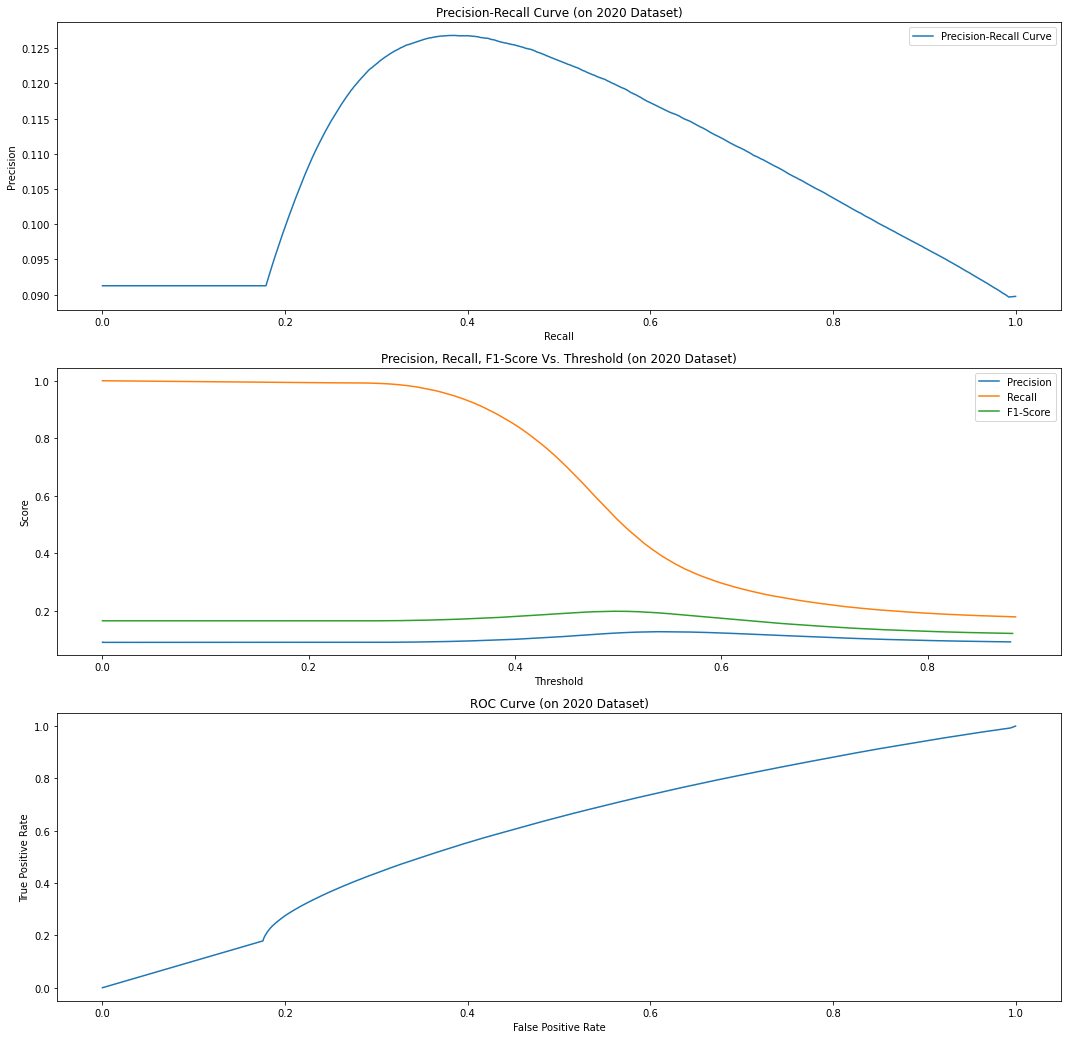

In [0]:
plotMetrics(lr_predictions_2020)

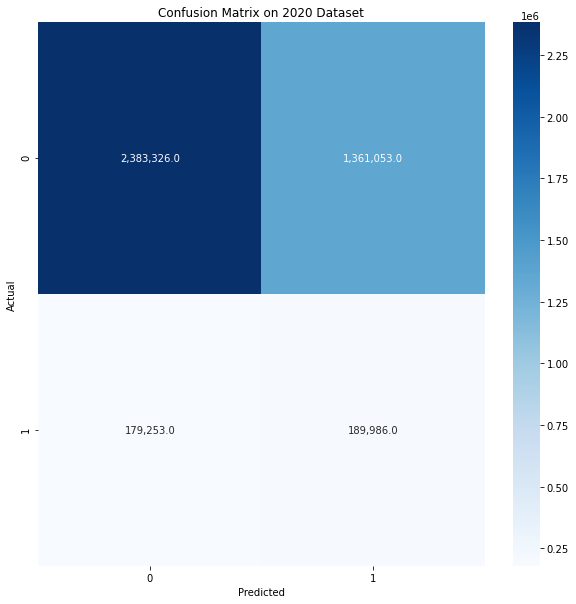

In [0]:
plotConfusionMatrix(lr_mcm)

In [0]:
lr_predictions_2020.createOrReplaceTempView('lr_2020')

In [0]:
display(monthlyMetrics('lr_2020'))

month true_positive true_negative false_positive false_negative precision recall f1score accuracy 1 42883 263486 204808 30024 0.1731310382694567 0.5881876911682006 0.267519 0.5660909717461719 2 44202 265506 173825 30032 0.2027363583409394 0.5954414419268799 0.302483 0.6030551147371803 3 23221 272625 174780 22271 0.1172771854687603 0.5104413962894575 0.190732 0.6002187069509451 4 2590 116032 48577 5882 0.0506185627455196 0.3057129367327668 0.086855 0.6853554116280816 5 3015 105627 49240 4909 0.0576978279590470 0.3804896516910651 0.100201 0.6673710463109140 6 7842 113541 86348 6029 0.0832572459921435 0.5653521735995963 0.145140 0.5678471182634731 7 14585 170419 139185 10334 0.0948494504779866 0.5852963602070709 0.163244 0.5530382066405001 8 12590 203288 128903 11593 0.0889796668386422 0.5206136542199065 0.151983 0.6057624854787386 9 5911 213969 77255 12178 0.0710747180338119 0.3267731770689369 0.116756 0.7108656926802301 10 8430 227988 84642 15437 0.0905750386797318 0.3532073574391419 0.144179 0.7025857585654553 11 7088 231698 85238 13824 0.0767714403310010 0.3389441469013007 0.125187 0.7067852998981791 12 17629 199147 108252 16740 0.1400449631000707 0.5129331665163374 0.220018 0.6342782238243487

### Decision Tree Model

In [0]:
tree_model = DecisionTreeClassificationModel.load(f'{blob_url}/tree.model')

In [0]:
# eval the model on 2020 dataset
tree_predictions_2020 = eval_model(tree_model, df_2020)

In [0]:
tree_results_df, tree_bcm, tree_mcm = metrics(tree_predictions_2020)

In [0]:
print(tree_results_df.T)

2020 Dataset
Area Under ROC 0.608837
Area Under PR 0.136206
F1 score 0.204086
Recall 0.373189
Precision 0.140446
Accuracy 0.738726

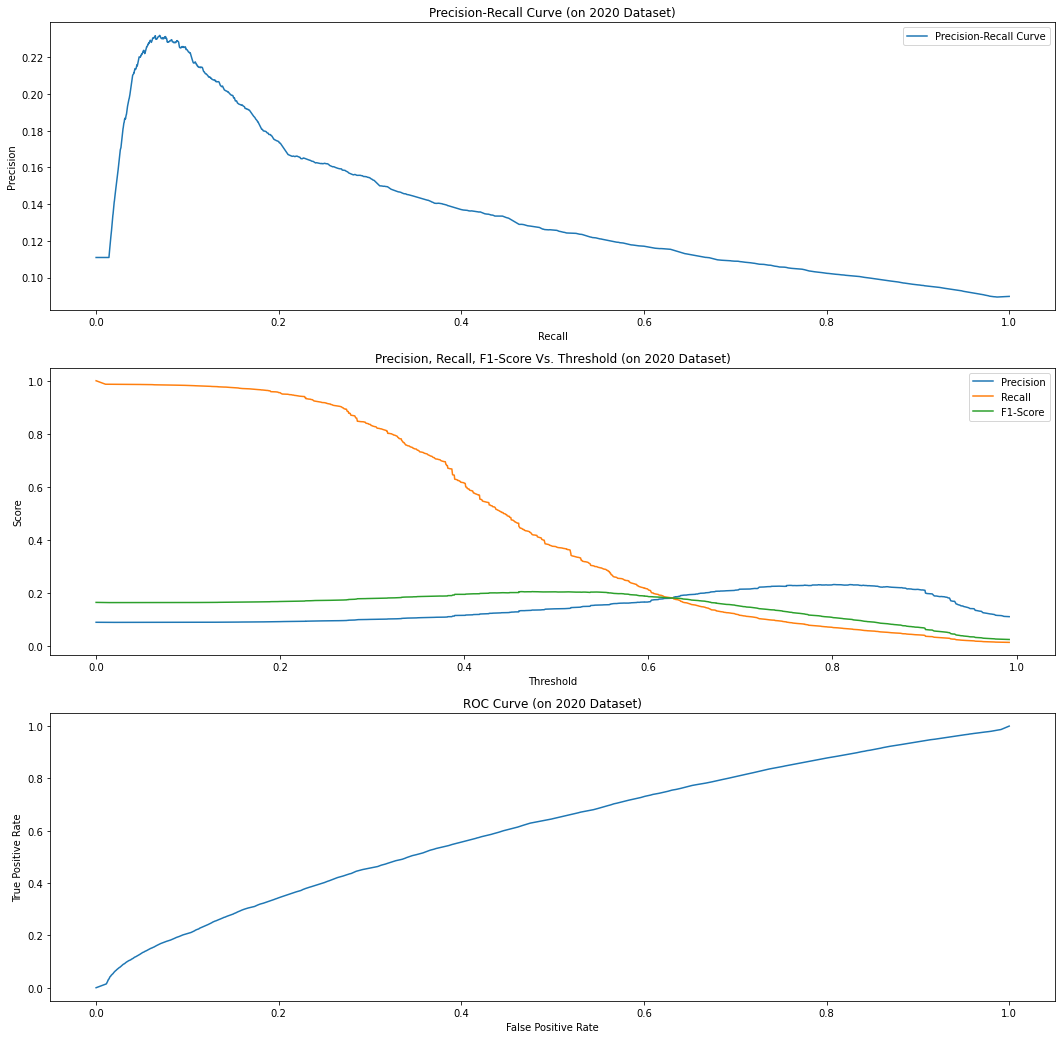

In [0]:
plotMetrics(tree_predictions_2020)

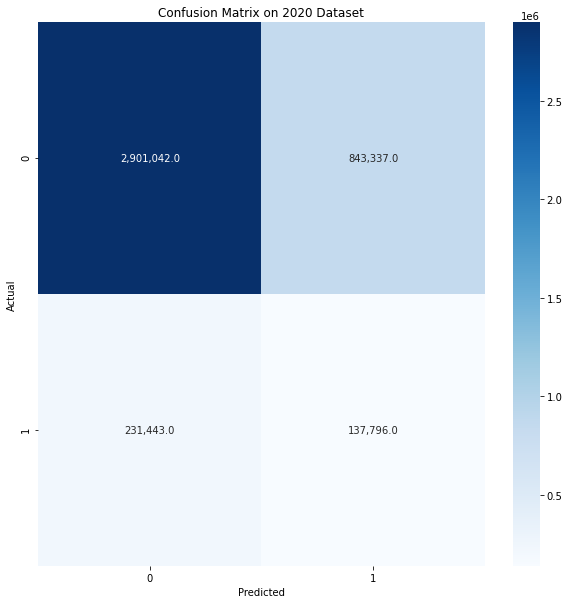

In [0]:
plotConfusionMatrix(tree_mcm)

In [0]:
tree_predictions_2020.createOrReplaceTempView('tree_2020')

In [0]:
display(monthlyMetrics('tree_2020'))

month true_positive true_negative false_positive false_negative precision recall f1score accuracy 1 31256 343604 124690 41651 0.2004283534043836 0.4287105490556462 0.273153 0.6926446920829784 2 34432 326086 113245 39802 0.2331574991366293 0.4638305897567153 0.310322 0.7019909845881242 3 15275 349936 97469 30217 0.1354839281913006 0.3357733227820276 0.193067 0.7409479059519535 4 1375 139396 25213 7097 0.0517150594253046 0.1622993389990557 0.078439 0.8133243972475315 5 1845 126350 28517 6079 0.0607667479085699 0.2328369510348309 0.096378 0.7874821089617976 6 6073 136448 63441 7798 0.0873636965215640 0.4378199120467162 0.145661 0.6667337200598802 7 11287 207680 101924 13632 0.0996987925201615 0.4529475500622015 0.163426 0.6545648580217205 8 9628 241362 90829 14555 0.0958420020506286 0.3981309184137617 0.154492 0.7042881916189172 9 3964 248672 42552 14125 0.0852179895089862 0.2191387030792194 0.122715 0.8167648951062516 10 6148 262507 50123 17719 0.1092569885020703 0.2575941676792224 0.153436 0.7983875041976600 11 4418 272164 44772 16494 0.0898150030494003 0.2112662586074981 0.126046 0.8186580947645095 12 12095 246837 60562 22274 0.1664670988342486 0.3519159707876284 0.226020 0.7576250555932679

### Gradient Boosted Trees Model

In [0]:
gbtree_model = GBTClassificationModel.load(f'{blob_url}/gbtree.model')

In [0]:
# eval the model on 2020 dataset
gbtree_predictions_2020 = eval_model(gbtree_model, df_2020)

In [0]:
gbtree_results_df, gbtree_bcm, gbtree_mcm = metrics(gbtree_predictions_2020)

In [0]:
print(gbtree_results_df.T)

2020 Dataset
Area Under ROC 0.618443
Area Under PR 0.170174
F1 score 0.214192
Recall 0.265589
Precision 0.179462
Accuracy 0.825081

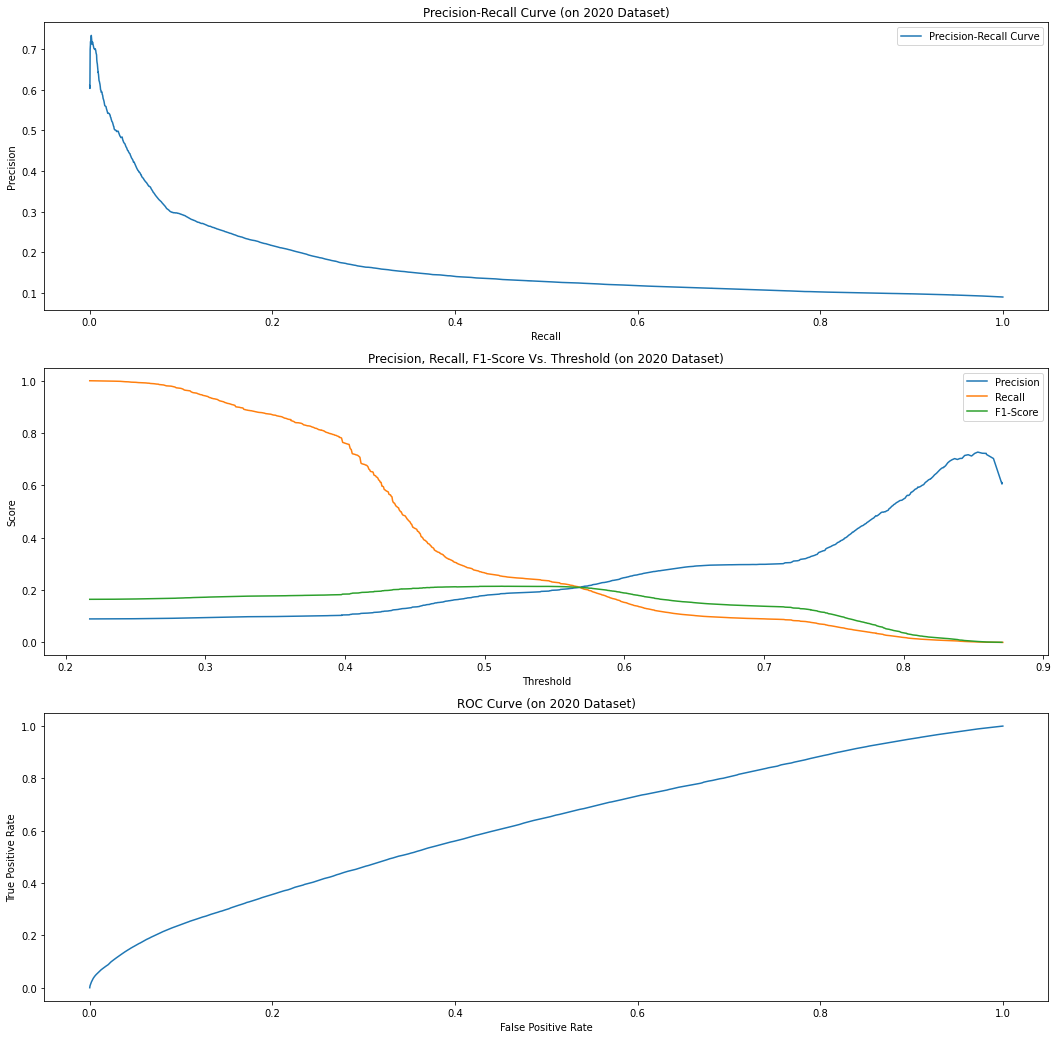

In [0]:
plotMetrics(gbtree_predictions_2020)

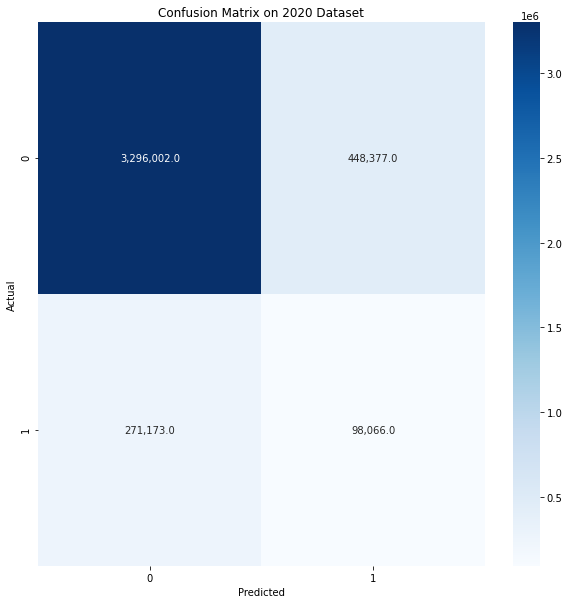

In [0]:
plotConfusionMatrix(gbtree_mcm)

In [0]:
gbtree_predictions_2020.createOrReplaceTempView('gbtree_2020')

In [0]:
display(monthlyMetrics('gbtree_2020'))

month true_positive true_negative false_positive false_negative precision recall f1score accuracy 1 25076 382715 85579 47831 0.2266142515024174 0.3439450258548562 0.273216 0.7534926949506745 2 29439 359971 79360 44795 0.2705815310802489 0.3965703047121265 0.321679 0.7582487124317272 3 10571 392557 54848 34921 0.1615891407695012 0.2323705266860107 0.190621 0.8178747283915301 4 842 151884 12725 7630 0.0620623571902410 0.0993862134088763 0.076408 0.8823961035584495 5 815 144501 10366 7109 0.0728915123870852 0.1028520949015649 0.085317 0.8926537707858543 6 2376 180101 19788 11495 0.1072008662696264 0.1712926249008723 0.131870 0.8536536302395210 7 5262 273236 36368 19657 0.1263992313235647 0.2111641719170111 0.158139 0.8325227263895158 8 4714 298208 33983 19469 0.1218182288032664 0.1949303229541413 0.149936 0.8500115047674634 9 2270 271699 19525 15819 0.1041523285157146 0.1254906296644370 0.113829 0.8857338682822901 10 4682 281594 31036 19185 0.1310823674337869 0.1961704445468639 0.157154 0.8507534985453065 11 2985 291616 25320 17927 0.1054583995760466 0.1427410099464422 0.121298 0.8719927304586678 12 9034 267920 39479 25335 0.1862181270999526 0.2628531525502633 0.217997 0.8103567332225369

### XGBoost Model

In [0]:
xgboost_model = XgboostClassifierModel.load(f'{blob_url}/xgboost.model')

In [0]:
# eval the model on 2020 dataset
xgboost_predictions_2020 = eval_model(xgboost_model, df_2020)

In [0]:
xgboost_results_df, xgboost_bcm, xgboost_mcm = metrics(xgboost_predictions_2020)

In [0]:
print(xgboost_results_df.T)

2020 Dataset
Area Under ROC 0.644644
Area Under PR 0.195725
F1 score 0.226878
Recall 0.386395
Precision 0.160583
Accuracy 0.763625

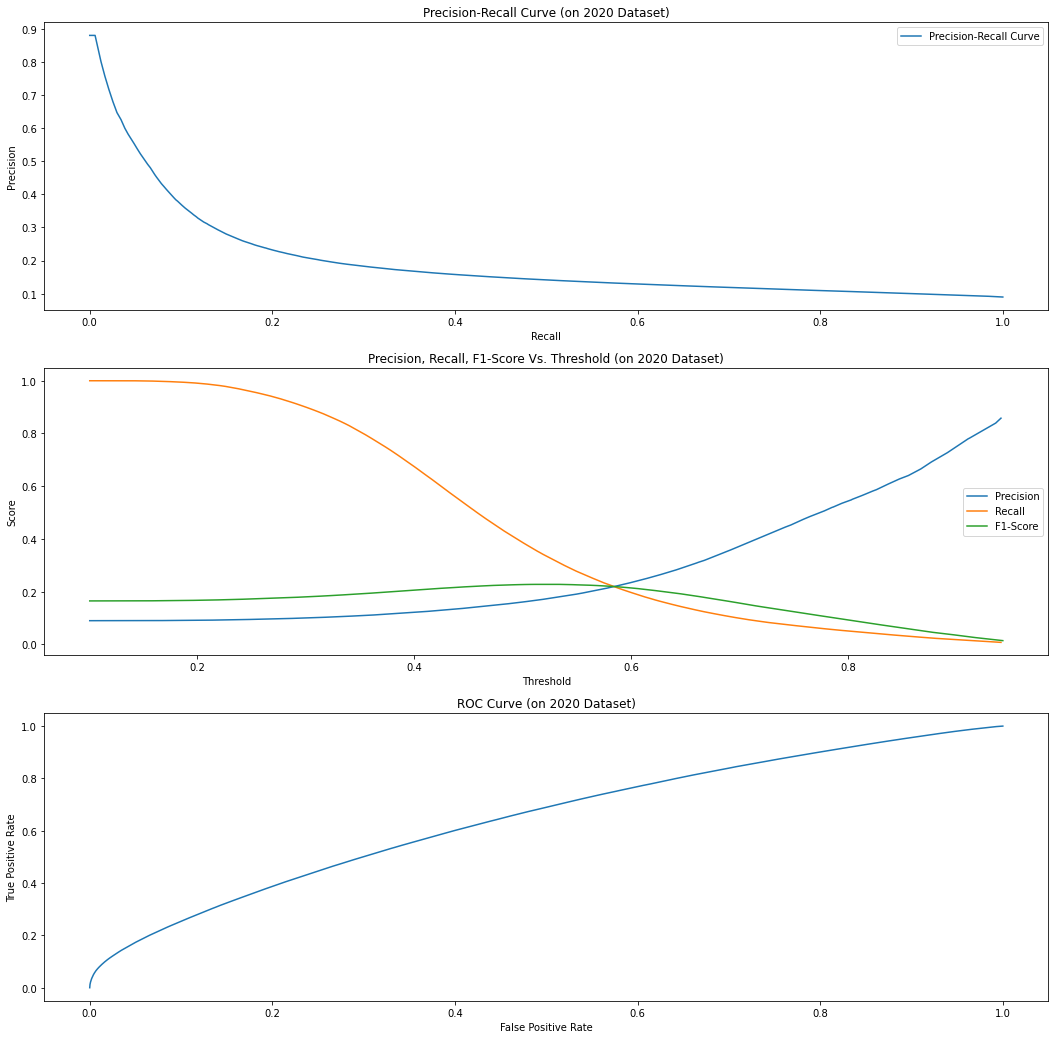

In [0]:
plotMetrics(xgboost_predictions_2020)

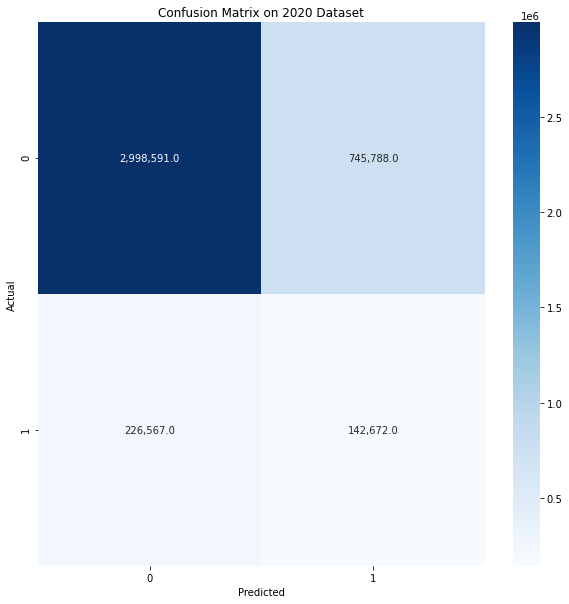

In [0]:
plotConfusionMatrix(xgboost_mcm)

In [0]:
xgboost_predictions_2020.createOrReplaceTempView('xgboost_2020')

In [0]:
display(monthlyMetrics('xgboost_2020'))

month true_positive true_negative false_positive false_negative precision recall f1score accuracy 1 32044 357427 110867 40863 0.2242234677526572 0.4395188390689509 0.296954 0.7196420553546649 2 36835 334640 104691 37399 0.2602701977021890 0.4962012016057332 0.341445 0.7233261612454120 3 15237 362979 84426 30255 0.1528852232021914 0.3349380110788710 0.209941 0.7673327287445450 4 1335 143830 20779 7137 0.0603689970154653 0.1575779036827195 0.087296 0.8387113547991981 5 1889 131480 23387 6035 0.0747349264124070 0.2383897021706209 0.113795 0.8192651927932134 6 6675 135852 64037 7196 0.0943969906097975 0.4812198111167183 0.157832 0.6667617889221557 7 12891 201220 108384 12028 0.1062956091527520 0.5173161041775352 0.176355 0.6400486663099398 8 10374 243084 89107 13809 0.1042812195293574 0.4289790348591986 0.167777 0.7112135004237122 9 3145 266711 24513 14944 0.1137103188950756 0.1738625684117419 0.137496 0.8724366580130806 10 5443 280941 31689 18424 0.1465851556608855 0.2280554740855575 0.178462 0.8510744523725323 11 3637 288431 28505 17275 0.1131541285545392 0.1739192807957154 0.137104 0.8644952759820985 12 13167 251996 55403 21202 0.1920227504739682 0.3831068695626873 0.255821 0.7758567215186910